In [2]:
import torch 
import numpy as np
from kmeans_gpu import KMeans
import sys
import os 
import matplotlib.colors as mcolors
sys.path.insert(0, os.path.abspath("/Users/samgende/Documents/Bachelor/DAS-Unsupervised-Noise-Filtering"))
from Code.utilities import cwt, paper_cwt, DAS
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


In [3]:
#Load clustering from the training Data
centers = torch.load('../Data/supports_inverse/gpuKmeansNZ_Dt_SS_centers', map_location='cpu').float()
labels = torch.load('../Data/supports_inverse/gpuKmeansNZ_Dt_SS_labels', map_location='cpu')
'Clustering is of the first 25 files'

'Clustering is of the first 25 files'

In [4]:
#get the counts of each cluster 
counts = np.zeros(centers.shape[0])
counts = np.bincount(labels, minlength=centers.shape[0])
print(f'cluster counts are {counts}') 

cluster counts are [ 1564361 41124853  1573586]


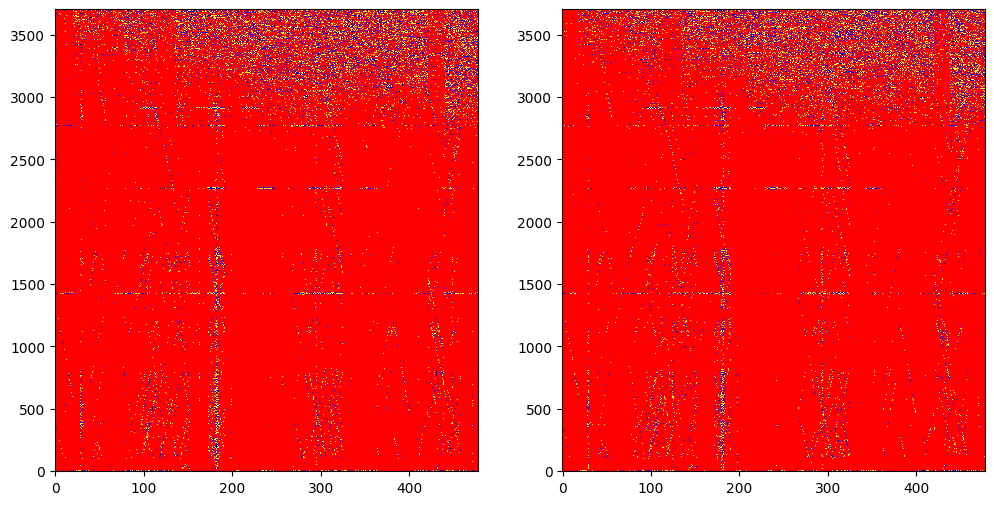

In [5]:
#Plot clusters on array
n_channels = 3704
n_samples = 478
labels_DAS_Form = torch.reshape(labels, (n_channels,  478, -1))
labels_DAS_Form.shape
cmap = mcolors.ListedColormap(['yellow', 'green', 'red', 'blue'])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.imshow(labels_DAS_Form[:,:,1], origin='lower', interpolation='nearest', cmap=cmap, aspect='auto')
ax2.imshow(labels_DAS_Form[:,:,20], origin='lower', interpolation='nearest', cmap=cmap, aspect='auto')

In [6]:
#Load transform from Testset
NZ_DAS, start_time = DAS.open_H5_file('../Data/2023p152354/south30_50Hz_UTC_20230226_085300.122.h5')
NZ_DAS.shape

(3000, 3704)

In [7]:
#parameters for cwt
dt =0.5
dj =0.5
w0 =8
minSpaceFrq = 0.002
maxSpaceFrq = 0.12
n_features = 30
n_channels = NZ_DAS.shape[0]
samples_per_second = 50
samples_per_sub_sample = 25
space_log = np.logspace(np.log10(minSpaceFrq), np.log10(maxSpaceFrq), n_features)
time_scales= cwt.get_scales(dt, dj, w0, n_samples)

transform = np.load("../Data/CWT_NewZealand/DT_SS/cwt_2023p313442.npy")

In [8]:
#get the prediction from the k-means centers
flatt_features = transform.reshape(transform.shape[0] * transform.shape[1], -1)
kmeans = KMeans(3, distance='euclidean')
flatt_labels = kmeans.predict(torch.tensor(flatt_features).float(), centers.float(), distance='euclidean').detach().numpy()
labels= np.reshape(flatt_labels, (transform.shape[0], transform.shape[1]))
car_clusters = [0,2]
flatt_mask = np.isin(flatt_labels, car_clusters)
mask  = np.reshape(flatt_mask, (transform.shape[0], transform.shape[1]))

In [48]:
#Decide what scales to Mute
n_scales_muted = 6

print(centers.shape)
differences = np.abs(centers[0,:time_scales.shape[0]] - centers[1,:time_scales.shape[0]])
rank = np.argsort(differences)

print(f'differences in time scales of centers {differences[rank][-n_scales_muted:]}')

scales_to_mute = np.zeros(time_scales.shape)
scales_to_mute[rank[-n_scales_muted:]] = 1
print(scales_to_mute)

torch.Size([3, 54])
differences in time scales of centers tensor([0.1945, 0.6480, 2.2552, 4.0941, 5.2996, 7.2268])
[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [49]:
# Mute the transform and do inverse CWT
#scales_to_mute = np.ones(time_scales.shape)
muted_inverse = cwt.mute((transform[:,:,:time_scales.shape[0]]), time_scales, mask, scales_to_mute, dj, dt, w0)
inverse = cwt.inverse_DAS(transform, time_scales, dj, dt, w0)

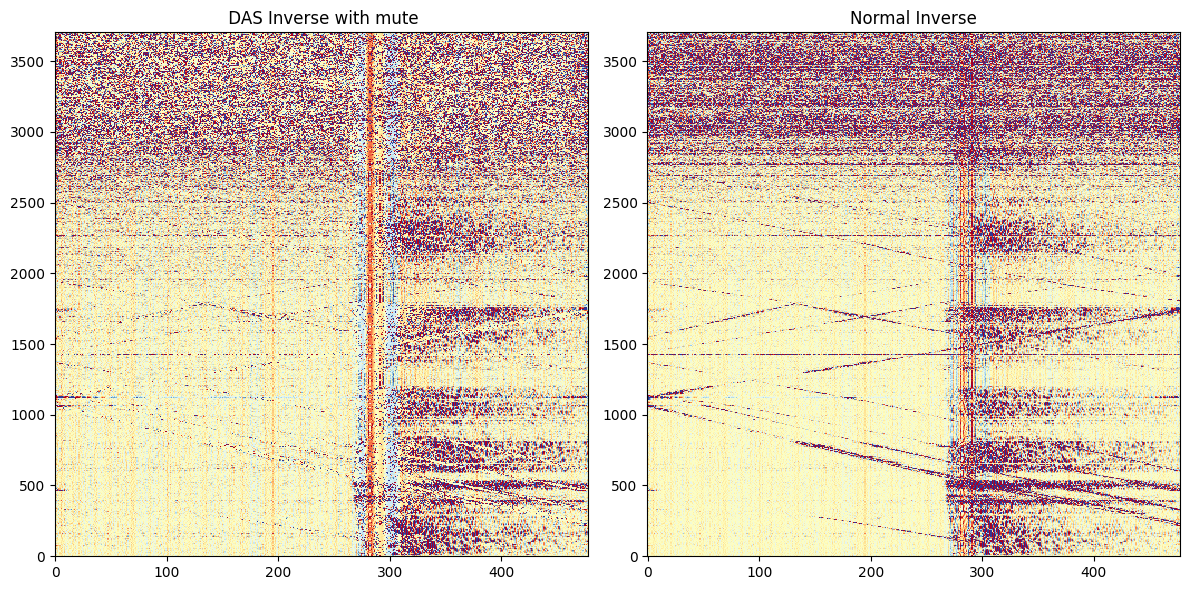

In [50]:
#Plot Muted DAS and Cluster Labels 
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(12,6))
ax1.imshow((muted_inverse / muted_inverse.std()), origin='lower', interpolation='nearest', cmap='RdYlBu', aspect='auto', vmin=-1, vmax=1)
cmap = mcolors.ListedColormap(['yellow', 'green', 'red', 'blue'])
ax2.imshow((inverse / inverse.std()), origin='lower', interpolation='nearest', cmap='RdYlBu', aspect='auto', vmin=-1, vmax=1)
ax1.set_title(" DAS Inverse with mute")
ax2.set_title("Normal Inverse")
plt.tight_layout()
plt.show()

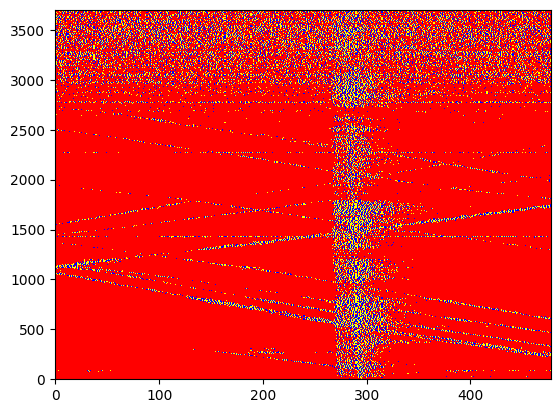

In [12]:
#Plot cluster distribution 
cmap = mcolors.ListedColormap(['yellow', 'green', 'red', 'blue'])
plt.imshow(labels, origin='lower', interpolation='nearest', cmap=cmap, aspect='auto')

In [13]:
#plot actual DAS sample 
das_dir = '../Data/2023p313442/'
files=  os.listdir(das_dir)
das = []
for file in files:
    data, starttime = DAS.open_H5_file(das_dir + file)
    das.append(data)
das = np.concatenate(das)
print(das.shape)
dt_das = das[1:,:] - das[:-1,:]
print(dt_das.shape)
print(np.array_equal(dt_das, das))

(12000, 3704)
(11999, 3704)
False


TypeError: 'Text' object is not callable

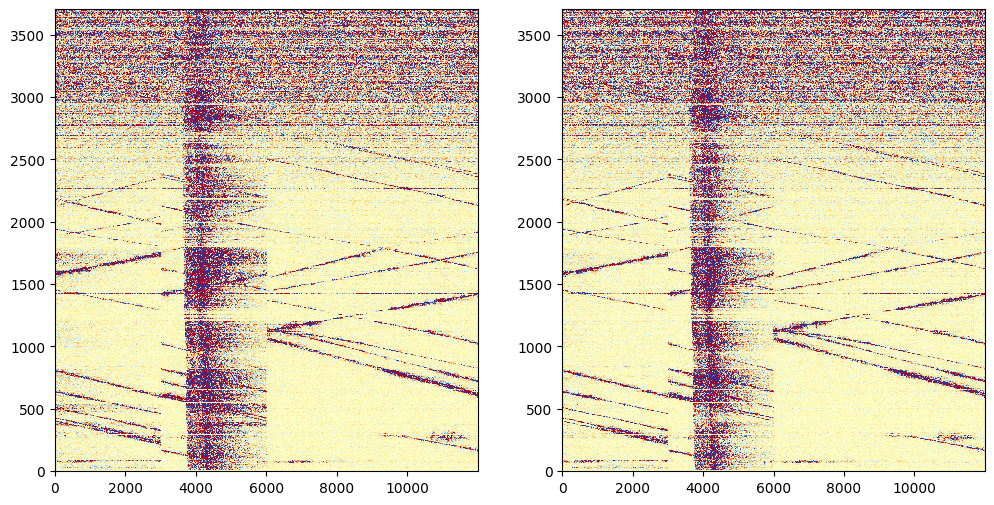

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(12,6))

ax1.imshow((das.T / das.T.std()), origin='lower', interpolation='nearest', cmap='RdYlBu', aspect='auto', vmin=-1, vmax=1)
ax2.imshow((dt_das.T / dt_das.T.std()), origin='lower', interpolation='nearest', cmap='RdYlBu', aspect='auto', vmin=-1, vmax=1)

ax1.title("Actual DAS Sample")
ax2.title("Differences of DAS Sample")